<a href="https://colab.research.google.com/github/pingwx/ya.prac/blob/main/13_ML_for_texts/13_RU_ML_for_texts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. В нашем распоряжении набор данных с разметкой о токсичности правок. Заказчик просит построить модель, классифицирующую комментарии на позитивные и негативные. Значение метрики качества *F1* должно быть не меньше 0.75

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

Откроем данные:

In [2]:
URL = #your dataset here
df_tweets = pd.read_csv(URL)
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Посмотрим на примеры:

In [3]:
df_tweets.sample(n=10, random_state=12345)

,text,toxic
146790,Ahh shut the fuck up you douchebag sand nigger...,1
2941,"""\n\nREPLY: There is no such thing as Texas Co...",0
115087,"Reply\nHey, you could at least mention Jasenov...",0
48830,"Thats fine, there is no deadline ) chi?",0
136034,"""\n\nDYK nomination of Mustarabim\n Hello! You...",0
121992,"""\n\nSockpuppetry case\n \nYou have been accus...",0
37282,"Judging by what I've just read in an article, ...",0
64488,Todd and Copper\nIn the first film they were l...,0
16992,"""\n\n \nYou have been blocked from editing for...",0
138230,| decline=Can't find evidence of block either ...,0


Осуждаем комментарий 146790!!!!! Отмечаем, что комментарии на английском языке, и в них достаточно много лишних символов.

Посмотрим на баланс классов:

In [4]:
df_tweets['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

Видим, что классы крайне несбалансированы.

Выполним предобработку текста, для этого определим функцию:

In [5]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return ' '.join(text.split())

Очистим комментарии от лишних символов:

In [6]:
df_tweets['cleared_text']  = df_tweets['text'].apply(clear_text)

Загрузим стоп-слова (язык - английский)

In [7]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Расчитаем матрицу TF-IDF на очищенных комментариях.

In [8]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords, max_features=5000)
tf_idf = count_tf_idf.fit_transform(df_tweets['cleared_text'])
tf_idf.shape

(159571, 5000)

## Обучение

Разобьем выборку на трейн, валид, тест.

In [9]:
y = df_tweets['toxic'].values
X_train, X_test, y_train, y_test = train_test_split(tf_idf, y, test_size=0.2, random_state=12345)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=12345)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((95742, 5000), (31914, 5000), (31915, 5000), (95742,), (31914,), (31915,))

Определиим функцию для подбора threshold

In [10]:
def get_best_threshold(y_val, proba):
    fpr, tpr, thresholds = roc_curve(y_val, proba)
    best_f1 = 0
    best_thresh = 0
    for threshold in thresholds:
        predict = proba > threshold 
        f1 = f1_score(y_val, predict)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = threshold
    plt.figure(figsize=(9, 9))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()
    print('best threshold:', best_thresh)
    return best_thresh

Обучим LogisticRegression и подберем для нее threshold

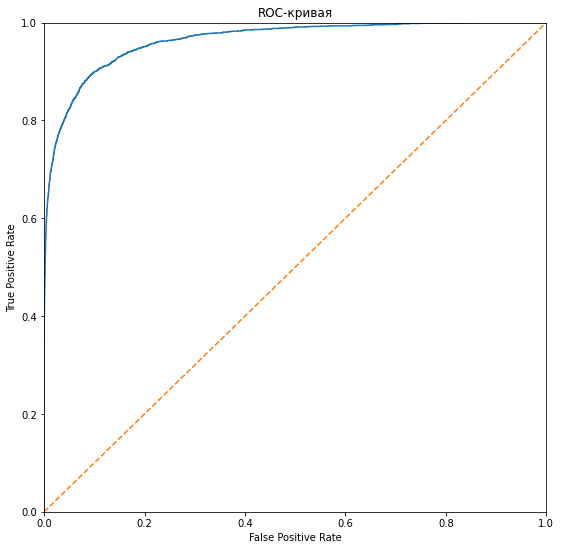

best threshold: 0.2700700243194629
f1 score: 0.7724569640062598


In [11]:
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)
proba = clf.predict_proba(X_val)[:, 1]
thresh = get_best_threshold(y_val, proba)
predict = proba > thresh
f1 = f1_score(y_val, predict)
print('f1 score:', f1)

### Тестирование

Запустим модель на тестовой выборке с подобранным threshold

In [12]:
test_proba = clf.predict_proba(X_test)[:, 1]
test_predict = test_proba > thresh
f1 = f1_score(y_test, test_predict)
print('f1 score:', f1)

f1 score: 0.7644688054167339


Метрика на тестовой выборке удовлетворяет требованиям!

## Попытки запуска BERT

У нас было несколько попыток запустить предварительно обученную модель BERT, и, наконец, мы нашли ту, которая отлично работает. См дополнительный ноутбук.

Кратко отметим особенности. Пробовали несколько моделей отсюда: https://huggingface.co/models от мала до велика.

А именно:
- DeepPavlov/rubert-base-cased-conversational
- DeepPavlov/distilrubert-tiny-cased-conversational
- DeepPavlov/bert-base-cased-conversational
- vinai/bertweet-base
- prajjwal1/bert-tiny
- unitary/toxic-bert

В дополнительном ноутбуке загружена модель toxic-bert, что позволило нам получить F1-оценку 0,9++. Окончательная матрица признаков после создания эмбеддингов намного меньше, чем сделана с использованием TF-IDF. По этой причине намного проще обучать классификаторы на эмбеддингах, можно пробовать разные и подбирать их параметры. Другие предварительно обученные модели показали нам итоговую f1-оценку в диапазоне от 0,5 до 0,7, что не соответствует требованиям задачи. 

## Выводы

Мы добились приемлевого качества работы модели, используя стандартные методы библиотеки sklearn. Для решения задачи был применен простейший подход. Он сработал благодаря тому, что исходный датасет имеет не очень большой размер. Даже опустив лемматизацию, размер TF-IDF оказался приемлемым.